1

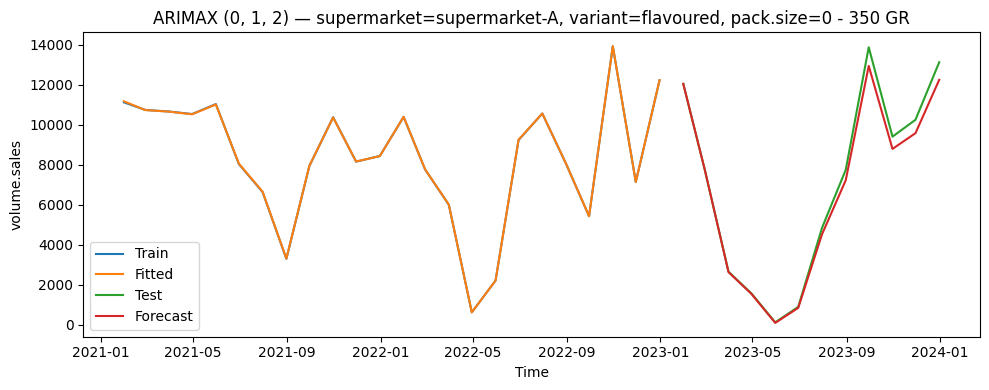

Serie: supermarket=supermarket-A, variant=flavoured, pack.size=0 - 350 GR
d detectado: 1
Orden (p,d,q): (0, 1, 2)
Exógenas: ['unit.sales', 'value.sales', 'price']
MAE: 338.212 | RMSE: 487.048 | MAPE(%): 5.63
Predicciones guardadas en: arimax_simple_predictions.csv


In [ ]:
# -*- coding: utf-8 -*-
# ARIMAX SIMPLE — 3 PASOS (modelo -> exógenas -> predicción)
import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

PATH = "C:\\Users\\ojimenezb\\OneDrive - Indra\\Documentos\\Personal\\VSC\\T\\TFG_ADE\\data\\data_GPT.xlsx"         # ruta a tu Excel
DATE_COL = "date"              # columna de fecha
TARGET_COL = "volume.sales"    # objetivo a predecir
SELECT_SERIES = None           # ejemplo: {"supermarket":"supermarket-A","variant":"flavoured","pack.size":"0 - 350 GR"}
KEYS = ["supermarket","variant","pack.size"]

def adf_d(s):
    s = s.dropna()
    if len(s) < 6 or s.nunique() < 4:
        return 0
    try:
        _, pval, *_ = adfuller(s, autolag="AIC")
        return 0 if pval < 0.05 else 1
    except Exception:
        return 1

def best_order(y, X, d, max_p=2, max_q=2):
    best = None
    for p in range(max_p+1):
        for q in range(max_q+1):
            if (p, d, q) == (0, 0, 0):
                continue
            try:
                res = SARIMAX(y, exog=X, order=(p, d, q),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                aic = res.aic
                if best is None or aic < best["aic"]:
                    best = {"order": (p, d, q), "aic": aic, "res": res}
            except Exception:
                continue
    return best

def choose_exog(train_df, target, candidates_pref=None, k_auto=3, exclude=()):
    chosen = []
    if candidates_pref:
        for c in candidates_pref:
            if c in train_df.columns and c not in exclude and pd.api.types.is_numeric_dtype(train_df[c]):
                chosen.append(c)
    if not chosen:
        num_cols = [c for c in train_df.columns
                    if c not in exclude
                    and pd.api.types.is_numeric_dtype(train_df[c])
                    and train_df[c].nunique() > 5]
        if num_cols:
            corr = train_df[num_cols].corrwith(train_df[target]).abs().sort_values(ascending=False)
            chosen = list(corr.head(k_auto).index)
    return chosen

def main():
    df = pd.read_excel(PATH)
    df.columns = [c.strip() for c in df.columns]
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

    if SELECT_SERIES is not None:
        mask = np.ones(len(df), dtype=bool)
        for k, v in SELECT_SERIES.items():
            mask &= (df[k] == v)
        work = df.loc[mask].copy()
        label = ", ".join([f"{k}={v}" for k, v in SELECT_SERIES.items()])
    else:
        keys_present = [k for k in KEYS if k in df.columns]
        if keys_present:
            top = df.groupby(keys_present, dropna=False).size().sort_values(ascending=False).index[0]
            if not isinstance(top, tuple): top = (top,)
            mask = np.ones(len(df), dtype=bool)
            series_dict = {}
            for i, k in enumerate(keys_present):
                series_dict[k] = top[i]
                mask &= (df[k] == top[i])
            work = df.loc[mask].copy()
            label = ", ".join([f"{k}={v}" for k, v in series_dict.items()])
        else:
            work = df.copy()
            label = "<global>"

    work = work.sort_values(DATE_COL).reset_index(drop=True)

    n = len(work)
    test_size = max(12, int(round(0.2 * n)))
    train = work.iloc[:-test_size] if n > test_size else work.iloc[:-1]
    test = work.iloc[-test_size:] if n > test_size else work.iloc[-1:]
    
    d = adf_d(train[TARGET_COL].astype(float))
    display(d)

    exclude_cols = {TARGET_COL, DATE_COL, *[k for k in KEYS if k in work.columns]}
    pref = ["unit.sales", "value.sales", "price"]
    exog_cols = choose_exog(train, TARGET_COL, candidates_pref=pref, k_auto=3, exclude=exclude_cols)

    y_tr = train[TARGET_COL].astype(float)
    X_tr = train[exog_cols].astype(float) if exog_cols else None
    y_te = test[TARGET_COL].astype(float)
    X_te = test[exog_cols].astype(float) if exog_cols else None

    best = best_order(y_tr, X_tr, d=d, max_p=2, max_q=2)
    if best is None:
        raise RuntimeError("No se pudo ajustar un ARIMAX válido.")
    order = best["order"]
    res = best["res"]

    fitted_tr = res.predict(start=y_tr.index[0], end=y_tr.index[-1], exog=X_tr)
    fc = res.get_forecast(steps=len(y_te), exog=X_te)
    fc_mean = pd.Series(fc.predicted_mean, index=y_te.index)

    mae = mean_absolute_error(y_te, fc_mean)
    rmse = math.sqrt(mean_squared_error(y_te, fc_mean))
    mape = float((np.abs((y_te - fc_mean) / np.maximum(1e-9, np.abs(y_te)))).mean() * 100.0)

    plt.figure(figsize=(10, 4))
    plt.plot(train[DATE_COL], y_tr, label="Train")
    plt.plot(train[DATE_COL], fitted_tr, label="Fitted")
    plt.plot(test[DATE_COL], y_te, label="Test")
    plt.plot(test[DATE_COL], fc_mean, label="Forecast")
    plt.title(f"ARIMAX {order} — {label}")
    plt.xlabel("Time")
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.tight_layout()
    plt.show()

    pred = pd.DataFrame({
        "time": pd.concat([train[DATE_COL], test[DATE_COL]]).values,
        "set": (["train"] * len(train)) + (["test"] * len(test)),
        "y_true": pd.concat([y_tr, y_te]).values,
        "y_hat": pd.concat([fitted_tr, fc_mean]).reindex(pd.concat([y_tr, y_te]).index).values
    })
    pred.to_csv("arimax_simple_predictions.csv", index=False)

    print("Serie:", label)
    print("d detectado:", d)
    print("Orden (p,d,q):", order)
    print("Exógenas:", exog_cols)
    print("MAE:", round(mae, 3), "| RMSE:", round(rmse, 3), "| MAPE(%):", round(mape, 2))
    print("Predicciones guardadas en: arimax_simple_predictions.csv")

if __name__ == "__main__":
    main()
